# Классифцікація тексту

Датасет

https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Класифікація на позитивні та негативні відгуки

In [1]:
# Підключаємо Google Drive з датасетами
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199673 sha256=cbe4a36f55d70266106308f14b015e263e10905055d23f0c7b947acb86cc2bd8
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [3]:
# Імпортуємо всі необхідні бібліотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn

sns.set()

%config InlineBackend.figure_format = "png"

# зчитуємо набір даних
datasets_path = "/content/drive/MyDrive/Colab Notebooks/imdb/"
df = pd.read_csv(datasets_path + "IMDB Dataset.csv", sep=",")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Датасет представляє собою корпус текстів і таргет, тож для классифікації стандартний фіча-інженірінг робити не потрібно. Зробимо лише енкодінг таргету.

# Підготовка датасету


Спочатку виконаємо конвертацію таргету в числове значення.

In [4]:
# Використаємо LabelEncoder для енкодінгу таргета
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["sentiment"] = le.fit_transform(df["sentiment"])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


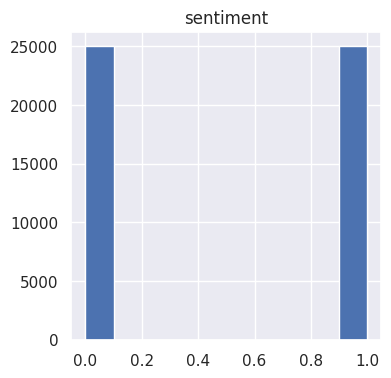

In [5]:
# Подивимось на розподіл по таргету
df.hist(figsize=(4, 4));

Можемо побачити, що це збалансований датасет.

In [6]:
import nltk
nltk.download("stopwords")

# Почистимо датасет від стоп-слів за допомогою NLTK
stopwords = nltk.corpus.stopwords.words("english")

df["review"] = df["review"].apply(lambda x: " ".join(term for term in x.split() if term not in stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Та приберемо HTML теги
import re
df["review"] = df["review"].apply(lambda x: re.compile(r'<[^>]+>').sub("", x))

In [ ]:
df.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,1
1,A wonderful little production. The filming tec...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically there's family little boy (Jake) thi...,0
4,"Petter Mattei's ""Love Time Money"" visually stu...",1


Для роботи в Colab поточний датасет має дуже багато рядків. Тож використаємо лише частину.

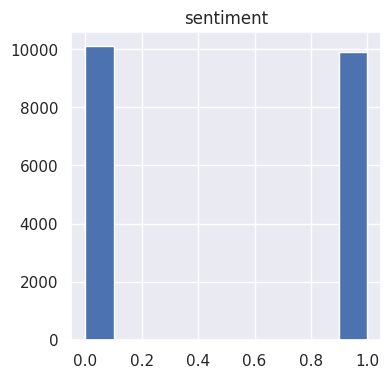

In [8]:
df_part = df[:20000]

# Подивимось на розподіл по таргету
df_part.hist(figsize=(4, 4));

Бачимо, що частина датасета, яка була взята для експериментів, є також доволі сбалансованої. Тож можемо продовжити. Зробимо копію цієї частини датасету та зробимо стеммінг за допомогою стеммера Портера, щоб можно було дослідити вплив стеммінгу на классифікацію.

In [37]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
df_part_stem = df_part.copy(deep=True)
df_part_stem["review"] = df_part["review"].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

In [38]:
df_part_stem.head()

,review,sentiment
0,one review mention watch 1 oz episod hooked. t...,1
1,a wonder littl production. the film techniqu u...,1
2,i thought wonder way spend time hot summer wee...,1
3,basic there' famili littl boy (jake) think the...,0
4,"petter mattei' ""love time money"" visual stun f...",1


# Класифікація

## Bag of words

Для створення bag of words моделі використаємо CountVectorizer iз Sklearn.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [26]:
# Створюємо векторайзер, на всяк випадок використовуємо вбудовану перевірку на стоп-слова
vectorizer = CountVectorizer(stop_words="english")

X = vectorizer.fit_transform(df_part["review"])
y = df_part["sentiment"]

In [27]:
# Зробимо масштабування фіч використовуючи MaxAbsScaler
scaler = MaxAbsScaler()
X = scaler.fit_transform(X)

In [28]:
# Ділимо збалансований датасет з використанням процесу стратифікації
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

In [29]:
# Спочатку побудуємо модель логістичної регресії
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(random_state=42)

# Навчаємо модель на тренувальних даних
logreg_model.fit(x_train, y_train)
predict = logreg_model.predict(x_test)

# Значення середньоквардатичної похибки
print("Результати тренування моделі LogisticRegression:")
print(
    "Середньоквадратична похибка:",
    mean_squared_error(y_test, predict),
)
# Подивимось на точність моделі на тестових даних
print(
    "Точність моделі на тестових даних:",
    logreg_model.score(x_test, y_test) * 100,
)

Результати тренування моделі LogisticRegression:
Середньоквадратична похибка: 0.1118
Точність моделі на тестових даних: 88.82


In [48]:
# Будуємо RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(x_train, y_train)
predict = random_forest_model.predict(x_test)

# Дивимось результати
print("Результати тренування моделі RandomForestClassifier:")
print(classification_report(y_test, predict))

Результати тренування моделі RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2524
           1       0.85      0.85      0.85      2476

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



Моделі логістичної регресії та RandomForestClassifier показують непогані результати. Але подивимось, чи вдасться їх покращити використовуючи стеммінг.

In [41]:
X_stem = vectorizer.fit_transform(df_part_stem["review"])
y_stem = df_part_stem["sentiment"]

In [42]:
# Зробимо масштабування фіч використовуючи MaxAbsScaler
X_stem = scaler.fit_transform(X_stem)

In [43]:
# Ділимо збалансований датасет з використанням процесу стратифікації
x_train, x_test, y_train, y_test = train_test_split(X_stem, y_stem, train_size=0.75, random_state=42, stratify=y)

In [46]:
# Навчаємо модель на тренувальних даних
logreg_model.fit(x_train, y_train)
predict = logreg_model.predict(x_test)

# Значення середньоквардатичної похибки
print("Результати тренування моделі LogisticRegression:")
print(
    "Середньоквадратична похибка:",
    mean_squared_error(y_test, predict),
)
# Подивимось на точність моделі на тестових даних
print(
    "Точність моделі на тестових даних:",
    logreg_model.score(x_test, y_test) * 100,
)

Результати тренування моделі LogisticRegression:
Середньоквадратична похибка: 0.1184
Точність моделі на тестових даних: 88.16000000000001


In [49]:
random_forest_model.fit(x_train, y_train)
predict = random_forest_model.predict(x_test)

# Дивимось результати
print("Результати тренування моделі RandomForestClassifier:")
print(classification_report(y_test, predict))

Результати тренування моделі RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2524
           1       0.85      0.85      0.85      2476

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



Як бачимо, стеммінг навіть трохи погіршив результат для цих моделей.

## TF-IDF

Для створення моделі TF-IDF використовуємо TfidfVectorizer із Sklearn.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
# Перевіримо спочатку на датасеті без стеммінгу
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_part["review"])

In [52]:
print(X)

  (0, 56828)	0.0464247834834236
  (0, 15786)	0.07323592547561396
  (0, 63972)	0.05684254752028629
  (0, 62783)	0.061805578887552004
  (0, 67508)	0.052341081410090806
  (0, 65552)	0.07052135405584238
  (0, 12944)	0.07406570622039035
  (0, 6275)	0.044600762715744764
  (0, 39234)	0.03654817119706222
  (0, 21951)	0.04735089295507998
  (0, 57327)	0.06492151824417919
  (0, 60194)	0.05526240376034571
  (0, 35432)	0.04790802107344358
  (0, 7224)	0.09641379767529965
  (0, 65020)	0.04936873406603326
  (0, 12162)	0.05170490807381564
  (0, 40248)	0.04974853847244981
  (0, 38534)	0.0829744269050425
  (0, 68692)	0.024904134956605466
  (0, 25852)	0.052443326968578945
  (0, 44626)	0.04948298546926544
  (0, 34639)	0.04773798875429902
  (0, 31905)	0.16933882058110147
  (0, 43080)	0.10002355841948948
  (0, 58221)	0.06799196044809933
  :	:
  (19999, 56999)	0.04149512820063229
  (19999, 3177)	0.041093293356612555
  (19999, 4304)	0.02747819364056081
  (19999, 38208)	0.06667300644838955
  (19999, 62909)	0.02

In [53]:
# Ділимо датасет
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

In [54]:
# Навчаємо модель на тренувальних даних
logreg_model.fit(x_train, y_train)
predict = logreg_model.predict(x_test)

# Значення середньоквардатичної похибки
print("Результати тренування моделі LogisticRegression:")
print(
    "Середньоквадратична похибка:",
    mean_squared_error(y_test, predict),
)
# Подивимось на точність моделі на тестових даних
print(
    "Точність моделі на тестових даних:",
    logreg_model.score(x_test, y_test) * 100,
)

Результати тренування моделі LogisticRegression:
Середньоквадратична похибка: 0.1054
Точність моделі на тестових даних: 89.46


In [ ]:
random_forest_model.fit(x_train, y_train)
predict = random_forest_model.predict(x_test)

# Дивимось результати
print("Результати тренування моделі RandomForestClassifier:")
print(classification_report(y_test, predict))

Результати тренування моделі RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2524
           1       0.86      0.84      0.85      2476

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



Використання моделі даних TF-IDF показує трохи кращі результати для класифікації за допомогою лінійної регресії и ті ж самі значення для класифікатора RandomForestClassifier. Подивимось, чи зможе стеммінг покращити ці метрики.

In [55]:
# Векторизуємо датасет зі стеммінгом
X_stem = vectorizer.fit_transform(df_part_stem["review"])
y_stem = df_part_stem["sentiment"]

In [56]:
# Ділимо збалансований датасет з використанням процесу стратифікації
x_train, x_test, y_train, y_test = train_test_split(X_stem, y_stem, train_size=0.75, random_state=42, stratify=y)

In [57]:
# Навчаємо модель на тренувальних даних
logreg_model.fit(x_train, y_train)
predict = logreg_model.predict(x_test)

# Значення середньоквардатичної похибки
print("Результати тренування моделі LogisticRegression:")
print(
    "Середньоквадратична похибка:",
    mean_squared_error(y_test, predict),
)
# Подивимось на точність моделі на тестових даних
print(
    "Точність моделі на тестових даних:",
    logreg_model.score(x_test, y_test) * 100,
)

Результати тренування моделі LogisticRegression:
Середньоквадратична похибка: 0.1154
Точність моделі на тестових даних: 88.46000000000001


In [58]:
random_forest_model.fit(x_train, y_train)
predict = random_forest_model.predict(x_test)

# Дивимось результати
print("Результати тренування моделі RandomForestClassifier:")
print(classification_report(y_test, predict))

Результати тренування моделі RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2524
           1       0.85      0.84      0.84      2476

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



Використання стеммінгу на цьому датасеті для моделей `Bag of words` та `TF-IDF` трохи знижує якість роботи моделей лінійної регресії та RandomForestClassifier. Можливо, потрібно використати інші моделі класифікації, або зробити додаткові маніпуляції над датасетом.

## Word2Vec

Для ознайомлення з word2vec будемо використовувати Gensim.

In [10]:
import gensim

In [16]:
# Ділимо датасет
X = df_part["review"]
y = df_part["sentiment"]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

Gensim дозволяє побудувати word2vec модель на базі моделей `CBOW` (Continuous Bag of Words) або `skip-gram` Спочатку подивимось як працює модель з CBOW.

In [72]:
w2v_cbow_model = gensim.models.Word2Vec(
    x_train.apply(lambda x: x.split(" ")),
    window=3,
    min_count=1,
    sg=0,  # 0=CBOW, 1=Skip-gram
)

print(w2v_cbow_model)

Word2Vec<vocab=211395, vector_size=100, alpha=0.025>


In [73]:
w2v_cbow_model.wv.most_similar("perfect")

[('amazing', 0.9600692391395569),
 ('brilliant', 0.9573836922645569),
 ('incredible', 0.9566738605499268),
 ('wonderful', 0.955535352230072),
 ('fantastic', 0.9540208578109741),
 ('terrific', 0.952296257019043),
 ('unusual', 0.9482255578041077),
 ('fine', 0.9470881819725037),
 ('textbook', 0.944088339805603),
 ('fascinating', 0.9439427852630615)]

In [74]:
len(w2v_cbow_model.wv.index_to_key)

211395

In [19]:
def vectorize(x_train, x_test, model):
  x_train_vect = np.array(
    [
        np.array(
            [model.wv[i] for i in ls if i in words]
        ) for ls in x_train
    ]
  )
  x_test_vect = np.array(
      [
          np.array(
              [model.wv[i] for i in ls if i in words]
          ) for ls in x_test
      ]
  )
  return x_train_vect, x_test_vect

In [76]:
words = set(w2v_cbow_model.wv.index_to_key)
x_train_vect, x_test_vect = vectorize(x_train, x_test, model=w2v_cbow_model)

<ipython-input-75-ebb3af80a716>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train_vect = np.array(
<ipython-input-75-ebb3af80a716>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test_vect = np.array(


In [77]:
for i, v in enumerate(x_train_vect[:5]):
    print(len(x_train.iloc[i]), len(v))

1883 1097
2199 1340
676 406
413 241
346 213


Можна побачити що після векторізації отримуємо вектори різної довжини. Якщо ми передамо такі дані на класифікацію, то отримаємо помилку. Тому потрібно зробити усереднення векторів тренувального та тестового датасетів.

In [20]:
def avarage_vects(x_train, x_test):
  x_train_vect_avg = []

  for v in x_train_vect:
      if v.size:
          x_train_vect_avg.append(v.mean(axis=0))
      else:
          x_train_vect_avg.append(np.zeros(100, dtype=float))

  x_test_vect_avg = []

  for v in x_test_vect:
      if v.size:
          x_test_vect_avg.append(v.mean(axis=0))
      else:
          x_test_vect_avg.append(np.zeros(100, dtype=float))

  return x_train_vect_avg, x_test_vect_avg

In [79]:
x_train_vect_avg, x_test_vect_avg = avarage_vects(x_train_vect, x_test_vect)

In [80]:
for i, v in enumerate(x_train_vect_avg[:5]):
    print(len(x_train.iloc[i]), len(v))

1883 100
2199 100
676 100
413 100
346 100


In [81]:
# Навчаємо модель логістичної регресії на тренувальних даних
logreg_model.fit(x_train_vect_avg, y_train)
predict = logreg_model.predict(x_test_vect_avg)

# Значення середньоквардатичної похибки
print("Результати тренування моделі LogisticRegression:")
print(
    "Середньоквадратична похибка:",
    mean_squared_error(y_test, predict),
)
# Подивимось на точність моделі на тестових даних
print(
    "Точність моделі на тестових даних:",
    logreg_model.score(x_test_vect_avg, y_test) * 100,
)

Результати тренування моделі LogisticRegression:
Середньоквадратична похибка: 0.4526
Точність моделі на тестових даних: 54.74


In [82]:
from sklearn.svm import SVC

svc_model = SVC(random_state=42)
svc_model.fit(x_train_vect_avg, y_train)
predict = svc_model.predict(x_test_vect_avg)

# Дивимось результати
print("Результати тренування моделі SVC:")
print(classification_report(y_test, predict))

Результати тренування моделі SVC:
              precision    recall  f1-score   support

           0       0.55      0.64      0.59      2524
           1       0.56      0.47      0.51      2476

    accuracy                           0.55      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.55      0.55      0.55      5000



Для класифікації векторів замість RandomForestClassifier було використано SVC. Але SVC та логістична регресія показують не дуже добрі результати. Подивимось, як спрацює word2vec модель на базі скіп-грамів.

In [22]:
w2v_sgram_model = gensim.models.Word2Vec(
    x_train.apply(lambda x: x.split(" ")),
    window=3,
    min_count=1,
    sg=1,  # 0=CBOW, 1=Skip-gram
)

In [23]:
words = set(w2v_sgram_model.wv.index_to_key)
x_train_vect, x_test_vect = vectorize(x_train, x_test, model=w2v_sgram_model)
x_train_vect_avg, x_test_vect_avg = avarage_vects(x_train_vect, x_test_vect)

<ipython-input-19-ebb3af80a716>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train_vect = np.array(
<ipython-input-19-ebb3af80a716>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test_vect = np.array(


In [30]:
# Навчаємо модель на тренувальних даних
logreg_model.fit(x_train_vect_avg, y_train)
predict = logreg_model.predict(x_test_vect_avg)

# Значення середньоквардатичної похибки
print("Результати тренування моделі LogisticRegression:")
print(
    "Середньоквадратична похибка:",
    mean_squared_error(y_test, predict),
)
# Подивимось на точність моделі на тестових даних
print(
    "Точність моделі на тестових даних:",
    logreg_model.score(x_test_vect_avg, y_test) * 100,
)

Результати тренування моделі LogisticRegression:
Середньоквадратична похибка: 0.4342
Точність моделі на тестових даних: 56.58


In [32]:
svc_model.fit(x_train_vect_avg, y_train)
predict = svc_model.predict(x_test_vect_avg)

# Дивимось результати
print("Результати тренування моделі SVC:")
print(classification_report(y_test, predict))

Результати тренування моделі SVC:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52      2524
           1       0.54      0.63      0.58      2476

    accuracy                           0.56      5000
   macro avg       0.56      0.56      0.55      5000
weighted avg       0.56      0.56      0.55      5000



Результати покращились, але зовсім незначно. Для підвищення якості класифікації, можливо, треба спробувати іншу розмірність векторів, замість дефолтної 100, або більш ретельно опрацювати датасет та отримані вектори.

## FastText

In [ ]:
import fasttext

Роздивимось окремо як за допомогою FastText можна вирішити задачу класифікації.

In [ ]:
# Ділимо датасет
X = df["review"]
y = df["sentiment"]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

Як я зрозумів, датасет для FastText повинен бути представлений лише у вигляді файла, де кожен рядок це речення у спеціальному форматі `__label__мітка речення`. Тому робимо файли з тренувальним та тестовим датасетами.

In [ ]:
with open("train_data.txt", "w", encoding="utf-8") as f:
    for i in range(len(x_train)):
        f.write("__label__" + str(y_train.iloc[i]) + " " + x_train.iloc[i] + "\n")

with open("test_data.txt", "w", encoding="utf-8") as f:
    for i in range(len(x_test)):
        f.write("__label__" + str(y_test.iloc[i]) + " " + x_test.iloc[i] + "\n")

In [ ]:
# Так як у нас є таргет, то обираємо supervised train
fasstext_model = fasttext.train_supervised(input="train_data.txt", epoch=50)

In [ ]:
result = fasstext_model.test("test_data.txt")
print("Test Accuracy:", result[1])

Test Accuracy: 0.88696


Дуже непоганий результат! Перевіримо як працює модель.

In [ ]:
text = "The movie was fantastic! I loved every minute of it."
labels, prob = fasstext_model.predict(text)
print(labels)
print(prob)
print("Label:", labels[0])
print("Probability:", prob[0])

('__label__1',)
[1.00001001]
Label: __label__1
Probability: 1.0000100135803223


Можемо зробити висновок, що FastText дозволяє дуже просто натренувати непогану модель для класифікації тексту, але слід мати на увазі обмеження і формат тренувальних та тестових даних.

# TensorFlow

Додатково подивимось як можно вирішити задачу класифікації тексту за допомогою Tensorflow.

In [24]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [26]:
# Ділимо датасет
X = df_part["review"]
y = df_part["sentiment"]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

In [27]:
# Задамо деякі параметри, такі як розмір словника,
# максимальна довжина речення, як буде обрізатись речення та значення для OOV токена
vocab_size = 10000
max_length = 120
trunc_type = "post"
oov_tok = "<OOV>"

# Ініціалізуємо токенайзер
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Генеруємо індекс слів з тренувальної частини
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

# Генеруємо тренувальні послідовності та робимо паддінг
sequences = tokenizer.texts_to_sequences(x_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Генеруємо тестові послідовності та робимо паддінг
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [28]:
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Створимо модель нейронної мережі, з використанням ебмедінгу та двонаправленого LSTM шару
# Так як у нас 2 категорії таргету, то на останньому слої використовуємо sigmoid функцію активації
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Задаємо параметри компіляції моделі
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Подивимось на опис моделі
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Тренуэмо модель 10 епох
history = model_lstm.fit(padded, y_train, batch_size=128, epochs=10, validation_data=(testing_padded, y_test))

Epoch 1/10
118/118 [==============================] - 32s 210ms/step - loss: 0.6418 - accuracy: 0.6064 - val_loss: 0.4398 - val_accuracy: 0.8578
Epoch 2/10
118/118 [==============================] - 24s 198ms/step - loss: 0.3478 - accuracy: 0.8675 - val_loss: 0.3108 - val_accuracy: 0.8698
Epoch 3/10
118/118 [==============================] - 20s 172ms/step - loss: 0.2256 - accuracy: 0.9179 - val_loss: 0.3263 - val_accuracy: 0.8718
Epoch 4/10
118/118 [==============================] - 22s 186ms/step - loss: 0.1590 - accuracy: 0.9474 - val_loss: 0.3482 - val_accuracy: 0.8682
Epoch 5/10
118/118 [==============================] - 20s 172ms/step - loss: 0.1154 - accuracy: 0.9659 - val_loss: 0.3721 - val_accuracy: 0.8618
Epoch 6/10
118/118 [==============================] - 20s 172ms/step - loss: 0.0916 - accuracy: 0.9735 - val_loss: 0.4311 - val_accuracy: 0.8612
Epoch 7/10
118/118 [==============================] - 20s 171ms/step - loss: 0.0662 - accuracy: 0.9821 - val_loss: 0.4852 - val_ac

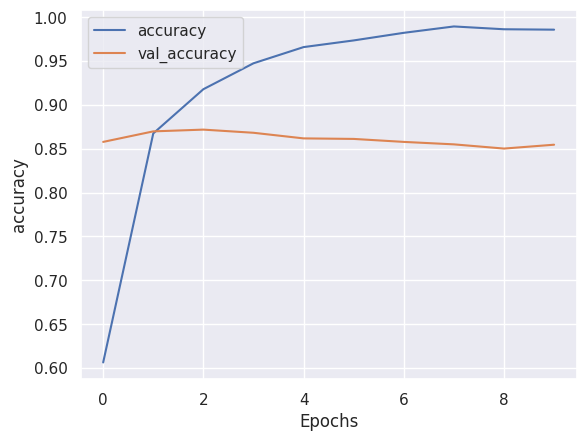

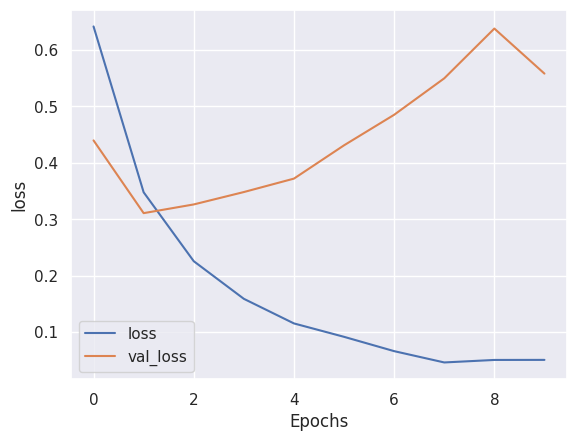

In [30]:
# Намалюємо графік зміни accuracy та loss моделі
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Як бачимо, модель перенавчилась на тренувальних даних. Для того, щоб прибрати перенавчання потрібно спробувати змінити архітектуру моделі (наприклад, замість LSTM використати convolutional шари), чи замінити оптимайзер на інший (чи погратися з learning rate параметром оптимайзера).

# Sentiment analysis

Подивимось як можна зробити sentiment analysis за допомогою біблотек NLTK та spaCy.

## NLTK

In [8]:
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import mark_negation, extract_unigram_feats

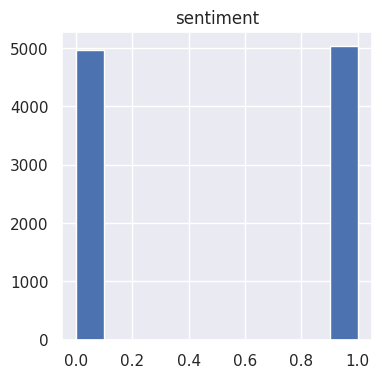

In [11]:
# NLTK на датасеті з 20к рядків з'їв всю пам'ять колаба, тому спробуємо дати йому менший датасет
df_part_nltk = df_part.copy(deep=True)[:10000]
df_part_nltk.hist(figsize=(4, 4));

In [12]:
# Потрібно щоб дані були представлені у вигляді set(список слів речення, мітка категорії)
df_part_nltk["docs"] = df_part_nltk.apply(lambda x: (x["review"].split(), x["sentiment"]), axis=1)
docs = df_part_nltk["docs"].tolist()

In [13]:
print(docs[:1])

[(['One', 'reviewers', 'mentioned', 'watching', '1', 'Oz', 'episode', 'hooked.', 'They', 'right,', 'exactly', 'happened', 'me.The', 'first', 'thing', 'struck', 'Oz', 'brutality', 'unflinching', 'scenes', 'violence,', 'set', 'right', 'word', 'GO.', 'Trust', 'me,', 'show', 'faint', 'hearted', 'timid.', 'This', 'show', 'pulls', 'punches', 'regards', 'drugs,', 'sex', 'violence.', 'Its', 'hardcore,', 'classic', 'use', 'word.It', 'called', 'OZ', 'nickname', 'given', 'Oswald', 'Maximum', 'Security', 'State', 'Penitentary.', 'It', 'focuses', 'mainly', 'Emerald', 'City,', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards,', 'privacy', 'high', 'agenda.', 'Em', 'City', 'home', 'many..Aryans,', 'Muslims,', 'gangstas,', 'Latinos,', 'Christians,', 'Italians,', 'Irish', 'more....so', 'scuffles,', 'death', 'stares,', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away.I', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare.', 'F

In [14]:
# Розбиваємо на тренувальну та тестові частини
train_docs = docs[:7500]
test_docs = docs[7500:]

In [15]:
# Ініціалізуємо аналізатор
sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in train_docs])
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [17]:
# Розмічаємо фічами датасети
training_set = sentim_analyzer.apply_features(train_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [18]:
# Тренуємо класифікатор
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

for key, value in sorted(sentim_analyzer.evaluate(test_set).items()):
  print(f"{key}: {value}")

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.8448
F-measure [0]: 0.8426601784266018
F-measure [1]: 0.8468823993685871
Precision [0]: 0.8365539452495975
Precision [1]: 0.8529411764705882
Recall [0]: 0.8488562091503268
Recall [1]: 0.8409090909090909


Метрики виглядають досить непогано. Також подивимось як працює VADER ( Valence Aware Dictionary for Sentiment Reasoning) модель.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

nltk.download("vader_lexicon")
nltk.download("punkt")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Створимо спиок речень з першого відгуду у датасеті
lines_list = tokenize.sent_tokenize(df["review"][0])
print(lines_list)

['One reviewers mentioned watching 1 Oz episode hooked.', 'They right, exactly happened me.The first thing struck Oz brutality unflinching scenes violence, set right word GO.', 'Trust me, show faint hearted timid.', 'This show pulls punches regards drugs, sex violence.', 'Its hardcore, classic use word.It called OZ nickname given Oswald Maximum Security State Penitentary.', 'It focuses mainly Emerald City, experimental section prison cells glass fronts face inwards, privacy high agenda.', 'Em City home many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish more....so scuffles, death stares, dodgy dealings shady agreements never far away.I would say main appeal show due fact goes shows dare.', 'Forget pretty pictures painted mainstream audiences, forget charm, forget romance...OZ mess around.', 'The first episode I ever saw struck nasty surreal, I say I ready it, I watched more, I developed taste Oz, got accustomed high levels graphic violence.', "Not violence, injustice 

In [ ]:
# Подивимось, як відпрацює модель
sid = SentimentIntensityAnalyzer()

for sentence in lines_list:
  print(sentence)
  ss = sid.polarity_scores(sentence)

  for k in sorted(ss):
    print(f"{k}: {ss[k]}, ", end="")

One reviewers mentioned watching 1 Oz episode hooked.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, They right, exactly happened me.The first thing struck Oz brutality unflinching scenes violence, set right word GO.
compound: -0.8779, neg: 0.419, neu: 0.581, pos: 0.0, Trust me, show faint hearted timid.
compound: 0.3182, neg: 0.215, neu: 0.43, pos: 0.355, This show pulls punches regards drugs, sex violence.
compound: -0.6249, neg: 0.369, neu: 0.631, pos: 0.0, Its hardcore, classic use word.It called OZ nickname given Oswald Maximum Security State Penitentary.
compound: 0.34, neg: 0.0, neu: 0.844, pos: 0.156, It focuses mainly Emerald City, experimental section prison cells glass fronts face inwards, privacy high agenda.
compound: -0.5106, neg: 0.18, neu: 0.82, pos: 0.0, Em City home many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish more....so scuffles, death stares, dodgy dealings shady agreements never far away.I would say main appeal show due fact goes shows dare.


## spaCy

In [74]:
import spacy

Для sentiment analysis у spaCy є компонент пайплайну spacytextblob. Давайте подивимось як він працює.

In [34]:
!pip install spacytextblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1


In [84]:
from spacytextblob.spacytextblob import SpacyTextBlob

In [38]:
# Загружаємо модель та додаємо spacytextblob пайплайн
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")
nlp.components

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7e5c08c73e20>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7e5c08c73ca0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7e5c08c78c10>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x7e5c08c73be0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7e5cf7bfc500>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7e5cf8651940>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7e5c08c78f20>),
 ('spacytextblob',
  <spacytextblob.spacytextblob.SpacyTextBlob at 0x7e5c08c0a5c0>)]

In [44]:
# Візьмемо перше речення
sentence = df_part["review"][0]
sentence

"One reviewers mentioned watching 1 Oz episode hooked. They right, exactly happened me.The first thing struck Oz brutality unflinching scenes violence, set right word GO. Trust me, show faint hearted timid. This show pulls punches regards drugs, sex violence. Its hardcore, classic use word.It called OZ nickname given Oswald Maximum Security State Penitentary. It focuses mainly Emerald City, experimental section prison cells glass fronts face inwards, privacy high agenda. Em City home many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish more....so scuffles, death stares, dodgy dealings shady agreements never far away.I would say main appeal show due fact goes shows dare. Forget pretty pictures painted mainstream audiences, forget charm, forget romance...OZ mess around. The first episode I ever saw struck nasty surreal, I say I ready it, I watched more, I developed taste Oz, got accustomed high levels graphic violence. Not violence, injustice (crooked guards who'll sold 

In [51]:
# Подивимось на метрики
doc = nlp(sentence)
print("Polarity:")
print(doc._.blob.polarity, "\n")

print("Subjectivity:")
print(doc._.blob.subjectivity, "\n")

print("Assessments:")
print(doc._.blob.sentiment_assessments.assessments, "\n")

print("Ngrams:")
print(doc._.blob.ngrams(), "\n")

Polarity:
0.04194581280788177 

Subjectivity:
0.4983251231527094 

Assessments:
[(['right'], 0.2857142857142857, 0.5357142857142857, None), (['exactly'], 0.25, 0.25, None), (['first'], 0.25, 0.3333333333333333, None), (['right'], 0.2857142857142857, 0.5357142857142857, None), (['faint'], -0.5, 1.0, None), (['classic'], 0.16666666666666666, 0.16666666666666666, None), (['mainly'], 0.16666666666666666, 0.3333333333333333, None), (['experimental'], 0.1, 0.4, None), (['high'], 0.16, 0.5399999999999999, None), (['irish'], 0.0, 0.0, None), (['shady'], -0.25, 0.625, None), (['never', 'far'], -0.05, 1.0, None), (['main'], 0.16666666666666666, 0.3333333333333333, None), (['due'], -0.125, 0.375, None), (['pretty'], 0.25, 1.0, None), (['mess'], -0.175, 0.175, None), (['first'], 0.25, 0.3333333333333333, None), (['nasty'], -1.0, 1.0, None), (['surreal'], 0.25, 1.0, None), (['ready'], 0.2, 0.5, None), (['more'], 0.5, 0.5, None), (['developed'], 0.1, 0.3, None), (['high'], 0.16, 0.5399999999999999, 

# Висновок
В даній роботі ознайомились с різними моделями репрезентації тексту для NLP, такими як `Bag of word`, `TF-IDF`, `word2vec` та виконали ряд порівняльних класифікацій за допомогою даних, які ці моделі представляють. Також ознайомились з фреймворками та бібліотекам NLTK, spaCy, FastText та Gensim, а також з частиною інстрементів які представлені у цих біблотеках для класифікації та аналізу настрою тексту.